In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels
import statsmodels.sandbox.stats.multicomp
import pandas as pd
from statsmodels.stats.weightstats import ztest

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from sklearn.utils import shuffle
import hashlib
from base64 import b64encode
import collections
import datetime

# ДЗ 3:

1. Применить ранговую трансформацию (потом t-test) и сравнить с результатами по Манну-Уитни на:
- нормальном распределении (сгенерированные данные)
- метрике cart_added_cnt

2. Реализовать cuped-трансформацию и сравнить мощность t-критерия на:
- обычной метрике cart_added_cnt
- логарфимированной метрике cart_added_cnt
- метрике cart_added_cnt (а после подвергнуть ранговому преобразованию)


В каждом случае фиксировать, на сколько сокращается дисперсия, проверять равны ли средние в группах в ковариате и совпадают ли средние в метрике до и после применения cuped

3. Реализовать разбивку на бакеты, оценить t-критерием и сравнить с результатом без бакетирования:
- на логнормальном распределении (сгенерированные данные)
- на гамма-распределении (сгенерированные данные)
- на метрике cart_added_cnt

4. Реализовать постстратификацию на данных shop_metrics_old для метрики cart_added_cnt:
- на сочетании пола и возраста (возраст разбить на подгруппы: 18-24, 25-45, 46-60, 61-75, 76+)
- подсчитать результаты для случая без постстратификации и с постстратификацией
- на сколько сократилась диспресия?
- проверить мощность и корректность t-критерия для постстратифицированного случая

In [3]:
def salt_generator(salt=None):
    import os
    from base64 import b64encode
    salt = os.urandom(8)
    
    return b64encode(salt).decode('ascii')

In [4]:
def groups_splitter(df, user_salt=None):
    
    if user_salt == None:
        salt = salt_generator()
    else:
        salt = user_salt
    
    df['hash'] = ((df['user_id'].astype(str)) + '#' + salt).apply(lambda x: hashlib.sha256(x.encode('utf-8')).hexdigest())

    df['group'] = ((df['hash'].str.slice(start=-6).apply(int, base=16) % 2).map(lambda x: 'A' if x == 0 else 'B'))

    return df[['user_id', 'group']].drop_duplicates()

# 1. Ранговая трансформация
1. Применить ранговую трансформацию (потом t-test) и сравнить с результатами по Манну-Уитни на:
- нормальном распределении (сгенерированные данные)
- метрике cart_added_cnt

In [214]:
def array_ranker(a, b):
    from scipy.stats import rankdata
    
    a_con = np.ones([a.shape[0], 3])
    a_con[:,1] = a_con[:,1] * a

    b_con = np.ones([b.shape[0], 3])
    b_con[:,1] = b_con[:,1] * b
    b_con[:,0] = b_con[:,0] * 2

    c = np.concatenate((a_con, b_con))
    c[:,2] = rankdata(c[:,1])

    a_ranks = c[c[:,0] == 1][:,2]
    b_ranks = c[c[:,0] == 2][:,2]
    
    return a_ranks, b_ranks

In [215]:
def df_ranker(a, b, metric):
    df = pd.concat([a, b], axis = 0)
    df['rank'] = df[metric].rank()
    return df

## Нормальное распределение

100%|██████████| 1000/1000 [00:00<00:00, 1264.07it/s]


Effect = 5.06%


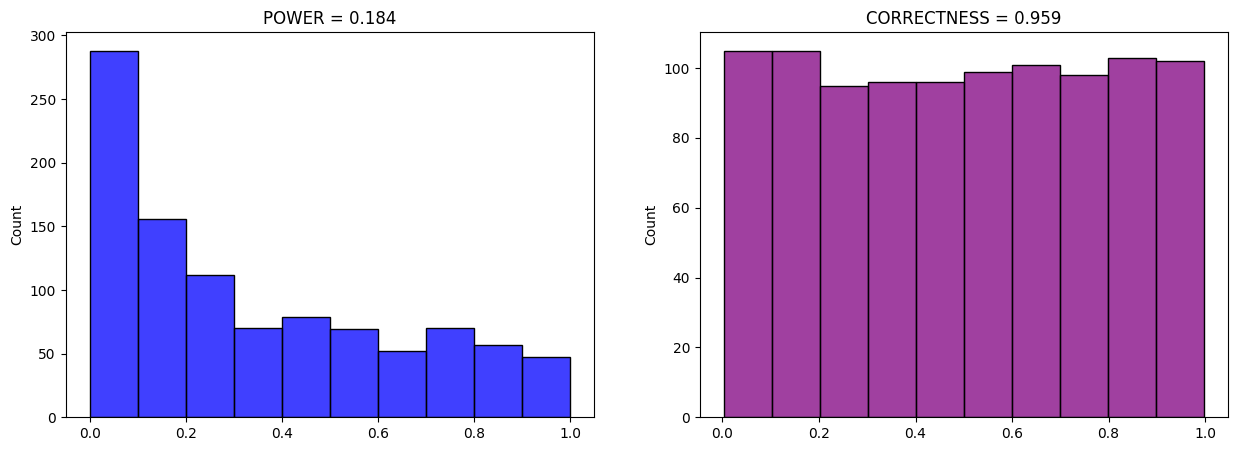

In [216]:
# Нормальное исходное - t-тест

effect = []
power = []
correctness = []

for i in tqdm(range(1000)): 
    
    a = np.random.normal(1, 1, 1000)
    b = np.random.normal(1, 1, 1000)
    b_effect = np.random.normal(1.05, 1, 1000)
    
    effect.append((b_effect.mean() - a.mean()) / a.mean())

    p_power, p_cor = stats.ttest_ind(a, b_effect)[1], stats.ttest_ind(a, b)[1]
    power.append(p_power)
    correctness.append(p_cor)
    
power = np.array(power)
correctness = np.array(correctness)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data=power, bins=10, color='blue', ax=ax[0])
ax[0].set_title(f'POWER = {power[power < 0.05].shape[0] / power.shape[0]}')

sns.histplot(data=correctness, bins=10, color='purple', ax=ax[1])
ax[1].set_title(f'CORRECTNESS = {1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])}')

print(f'Effect = {round(np.array(effect).mean() * 100, 2)}%')

100%|██████████| 1000/1000 [00:02<00:00, 383.52it/s]


Effect = 5.22%


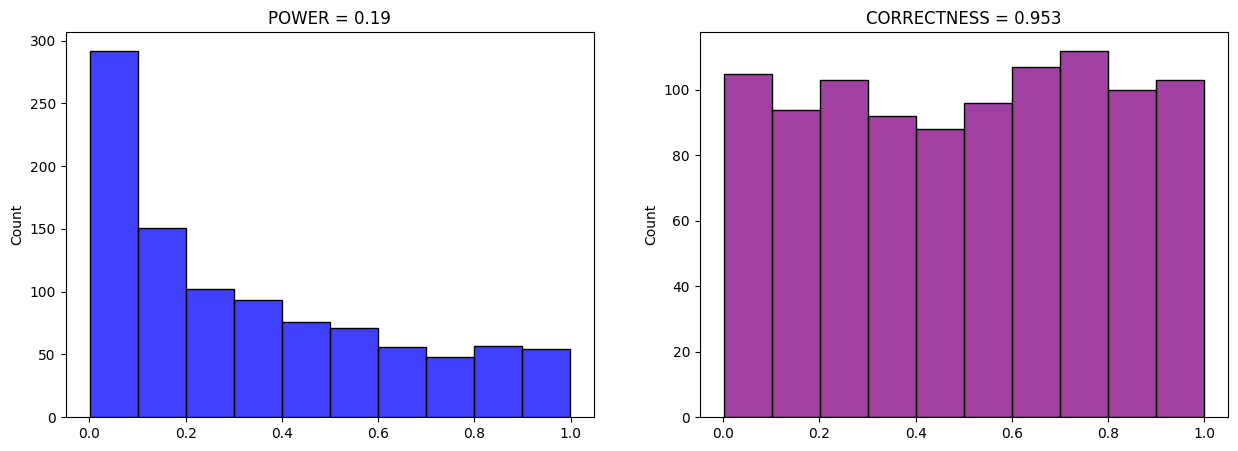

In [217]:
# Нормальное - ранговая трансформация - t-тест

effect = []
power = []
correctness = []

for i in tqdm(range(1000)): 
    
    a = np.random.normal(1, 1, 1000)
    b = np.random.normal(1, 1, 1000)
    b_effect = np.random.normal(1.05, 1, 1000)
    
    a_ranks, b_ranks = array_ranker(a, b)
    a_ranks_effect, b_effect_ranks = array_ranker(a, b_effect)
    
    effect.append((b_effect.mean() - a.mean()) / a.mean())

    p_power, p_cor = stats.ttest_ind(a_ranks_effect, b_effect_ranks)[1], stats.ttest_ind(a_ranks, b_ranks)[1]
    power.append(p_power)
    correctness.append(p_cor)

power = np.array(power)
correctness = np.array(correctness)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data=power, bins=10, color='blue', ax=ax[0])
ax[0].set_title(f'POWER = {power[power < 0.05].shape[0] / power.shape[0]}')

sns.histplot(data=correctness, bins=10, color='purple', ax=ax[1])
ax[1].set_title(f'CORRECTNESS = {1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])}')

print(f'Effect = {round(np.array(effect).mean() * 100, 2)}%')

100%|██████████| 1000/1000 [00:05<00:00, 179.02it/s]


Effect = 5.33%


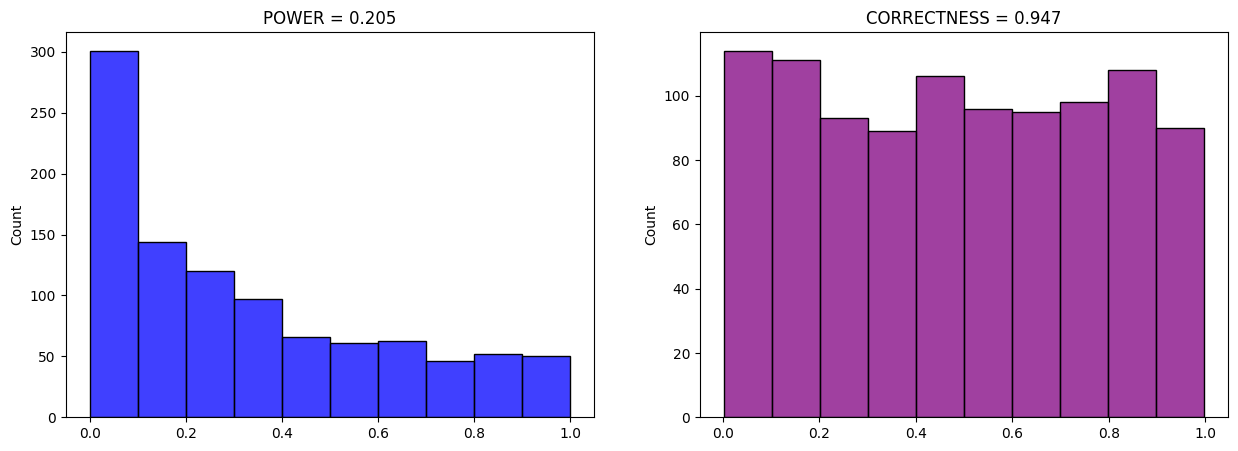

In [218]:
# Нормальное - Манн-Уитни

effect = []
power = []
correctness = []

for i in tqdm(range(1000)): 
    
    a = np.random.normal(1, 1, 1000)
    b = np.random.normal(1, 1, 1000)
    b_effect = np.random.normal(1.05, 1, 1000)
    
    effect.append((b_effect.mean() - a.mean()) / a.mean())

    p_power, p_cor  = stats.mannwhitneyu(a, b_effect)[1], stats.mannwhitneyu(a, b)[1]
    power.append(p_power)
    correctness.append(p_cor)

power = np.array(power)
correctness = np.array(correctness)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data=power, bins=10, color='blue', ax=ax[0])
ax[0].set_title(f'POWER = {power[power < 0.05].shape[0] / power.shape[0]}')

sns.histplot(data=correctness, bins=10, color='purple', ax=ax[1])
ax[1].set_title(f'CORRECTNESS = {1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])}')

print(f'Effect = {round(np.array(effect).mean() * 100, 2)}%')

**Ранги не помогли ускорить тест на нормальном распределении: все три варианта теста на выборках такого размера и с таким эффектом дали одинаковые результаты.**

## Датафрейм

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
shop_december = pd.read_csv('/content/drive/MyDrive/HW/shop_df_metrics_dec.csv').drop(columns='Unnamed: 0')

In [7]:
shop_december = shop_december.drop(columns=['group'])
shop_december.head(5)

,user_id,is_viewed,products_viewed_cnt,price_sum,is_cart_added,is_purchased,cart_added_cnt,purchased_cnt
0,1515915625353230683,1,1,339.79,0.0,0.0,0,0
1,1515915625353234047,1,9,861.86,0.0,0.0,0,0
2,1515915625353236157,1,4,179.60,0.0,0.0,0,0
3,1515915625353294441,1,28,4283.04,0.0,0.0,0,0
4,1515915625353386199,1,1,20.98,0.0,0.0,0,0


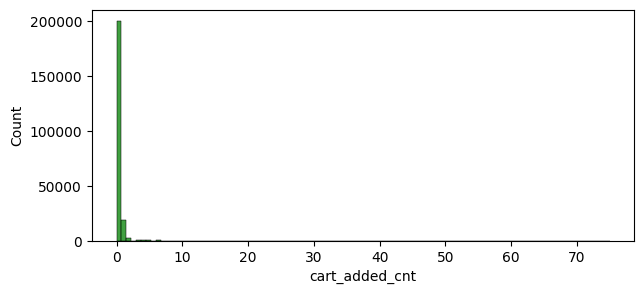

In [222]:
plt.figure(figsize=(7,3))
sns.histplot(data=shop_december, x='cart_added_cnt', bins=100, color='green');

100%|██████████| 1000/1000 [17:04<00:00,  1.02s/it]


Effect = 1.01%


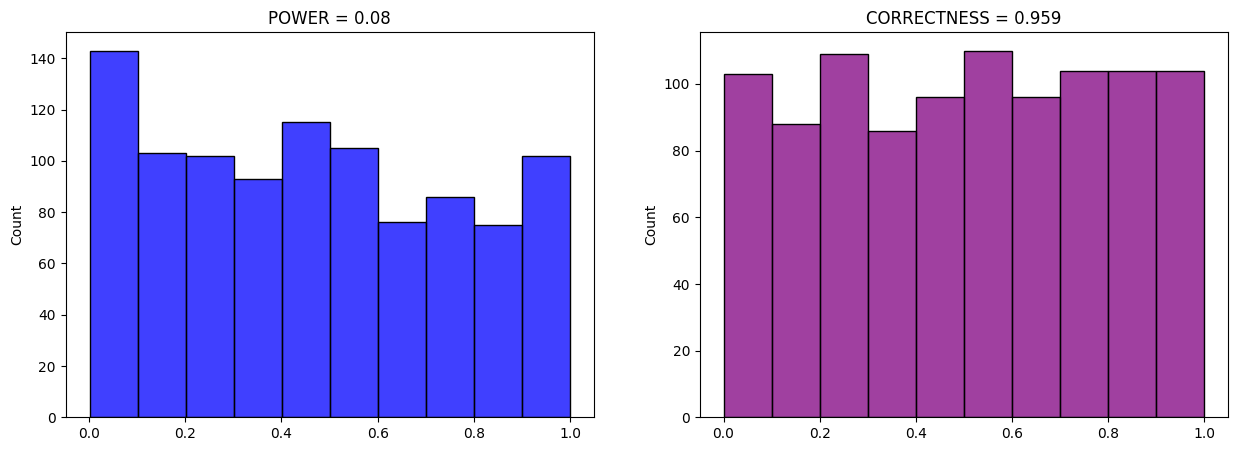

In [223]:
# cart_added_cnt - t-тест

effect = []
power = []
correctness = []

for i in tqdm(range(1000)):
    
    groups = groups_splitter(shop_december.copy(), user_salt=salt_generator())
    df = pd.merge(shop_december, groups, how="left", on=['user_id']).drop_duplicates()
    
    a = df[df['group'] == 'A']['cart_added_cnt']
    b = df[df['group'] == 'B']['cart_added_cnt']
    b_effect = b * 1.01
    
    effect.append((b_effect.mean() - a.mean()) / a.mean())

    p_power, p_cor = stats.ttest_ind(a, b_effect)[1], stats.ttest_ind(a, b)[1]
    power.append(p_power)
    correctness.append(p_cor)
    
power = np.array(power)
correctness = np.array(correctness)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data=power, bins=10, color='blue', ax=ax[0])
ax[0].set_title(f'POWER = {power[power < 0.05].shape[0] / power.shape[0]}')

sns.histplot(data=correctness, bins=10, color='purple', ax=ax[1])
ax[1].set_title(f'CORRECTNESS = {1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])}')

print(f'Effect = {round(np.array(effect).mean() * 100, 2)}%')

100%|██████████| 1000/1000 [21:19<00:00,  1.28s/it]


Effect = -0.17%


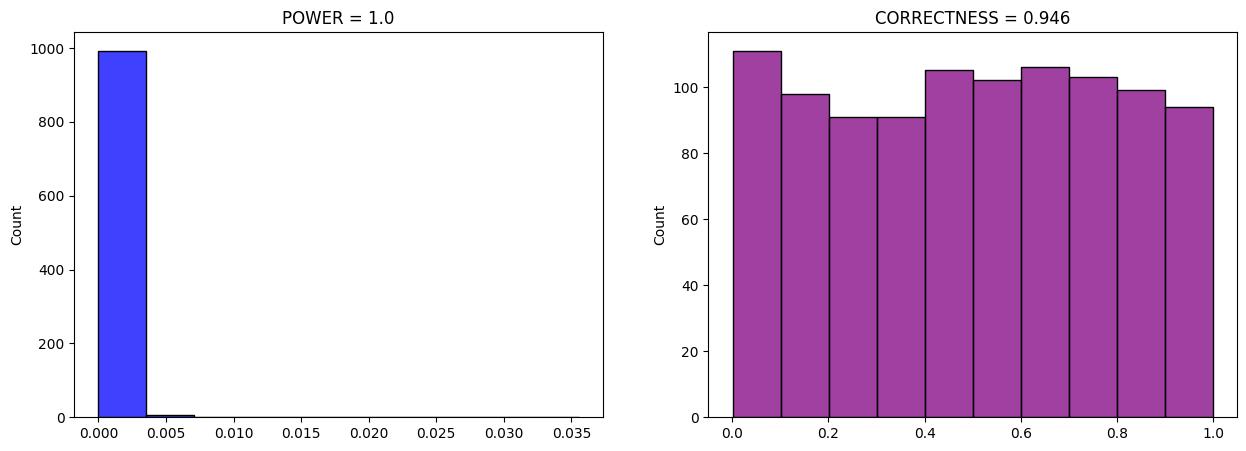

In [224]:
# cart_added_cnt - ранговая трансформация - t-тест

effect = []
power = []
correctness = []

for i in tqdm(range(1000)):
    
    groups = groups_splitter(shop_december.copy(), user_salt=salt_generator())
    df = pd.merge(shop_december, groups, how="left", on=['user_id']).drop_duplicates()
    
    a = df[df['group'] == 'A']['cart_added_cnt']
    b = df[df['group'] == 'B']['cart_added_cnt']
    b_effect = b * 1.0001
    
    effect.append((b_effect.mean() - a.mean()) / a.mean())
    
    df_ranked = df_ranker(df[df.group == 'A'], df[df.group == 'B'], 'cart_added_cnt')
    a_ranks = df_ranked[(df_ranked['group'] == 'A')]['rank']
    b_ranks = df_ranked[(df_ranked['group'] == 'B')]['rank']
    
    df_b = df[df.group == 'B'].drop(columns=['cart_added_cnt'])
    df_b['cart_added_cnt'] = list(b_effect)
    
    df_effect_ranked = df_ranker(df[df.group == 'A'], df_b, 'cart_added_cnt')
    a_ranks_effect = df_effect_ranked[(df_ranked['group'] == 'A')]['rank']
    b_effect_ranks = df_effect_ranked[(df_ranked['group'] == 'B')]['rank']

    p_power, p_cor = stats.ttest_ind(a_ranks_effect, b_effect_ranks)[1], stats.ttest_ind(a_ranks, b_ranks)[1]
    power.append(p_power)
    correctness.append(p_cor)
    
power = np.array(power)
correctness = np.array(correctness)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data=power, bins=10, color='blue', ax=ax[0])
ax[0].set_title(f'POWER = {power[power < 0.05].shape[0] / power.shape[0]}')

sns.histplot(data=correctness, bins=10, color='purple', ax=ax[1])
ax[1].set_title(f'CORRECTNESS = {1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])}')

print(f'Effect = {round(np.array(effect).mean() * 100, 2)}%')

100%|██████████| 1000/1000 [22:27<00:00,  1.35s/it]


Effect = -0.06%


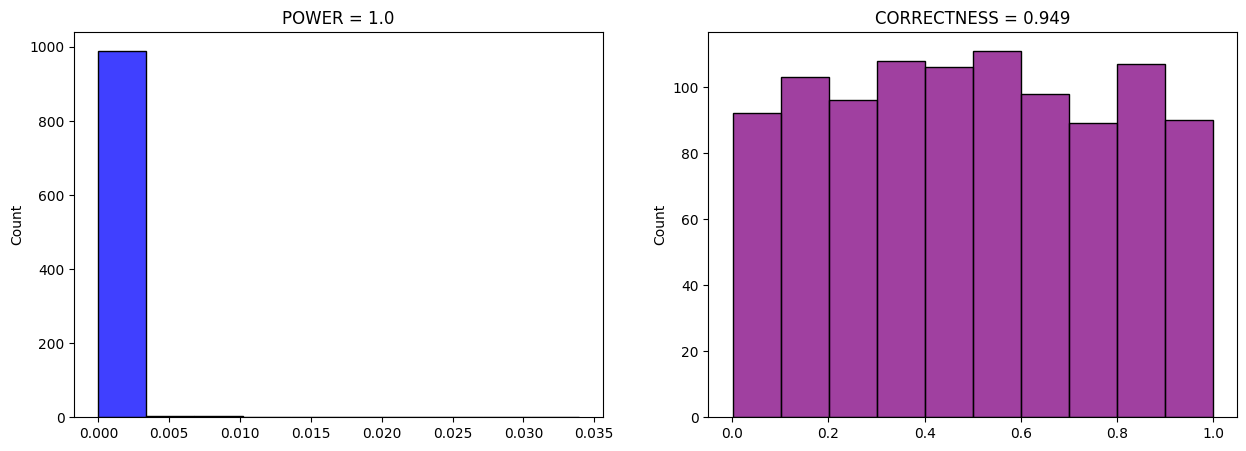

In [225]:
# cart_added_cnt - Манн-Уитни

effect = []
power = []
correctness = []

for i in tqdm(range(1000)):
    
    groups = groups_splitter(shop_december.copy(), user_salt=salt_generator())
    df = pd.merge(shop_december, groups, how="left", on=['user_id']).drop_duplicates()
    
    a = df[df['group'] == 'A']['cart_added_cnt']
    b = df[df['group'] == 'B']['cart_added_cnt']
    b_effect = b * 1.0001
    
    effect.append((b_effect.mean() - a.mean()) / a.mean())

    p_power, p_cor = stats.mannwhitneyu(a, b_effect)[1], stats.mannwhitneyu(a, b)[1]
    power.append(p_power)
    correctness.append(p_cor)
    
power = np.array(power)
correctness = np.array(correctness)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data=power, bins=10, color='blue', ax=ax[0])
ax[0].set_title(f'POWER = {power[power < 0.05].shape[0] / power.shape[0]}')

sns.histplot(data=correctness, bins=10, color='purple', ax=ax[1])
ax[1].set_title(f'CORRECTNESS = {1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])}')

print(f'Effect = {round(np.array(effect).mean() * 100, 2)}%')

**На ненормально распределённой метрике `cart_added_cnt` t-тест на рангах и тест Манна-Уитни показали гораздо более высокую мощность по сравнению с t-тестом на чистой метрике, при сохранении высокой корректности.**

# 2. CUPED
2. Реализовать cuped-трансформацию и сравнить мощность t-критерия на:
- обычной метрике cart_added_cnt
- логарфимированной метрике cart_added_cnt
- метрике cart_added_cnt (а после подвергнуть ранговому преобразованию)

В каждом случае фиксировать, на сколько сокращается дисперсия, проверять равны ли средние в группах в ковариате и совпадают ли средние в метрике до и после применения cuped

In [226]:
def cuped_transform(df, metric):

    new_columns = [str(m+'_cuped') for m in metric]
    df[new_columns] = pd.DataFrame([[0] * len(new_columns)], index=df.index)

    df_mini = df.fillna(0)
    for m in metric:
        covariate_column = str(m+'_covariate')
        cuped_column = str(m+'_cuped')
        mean_covariate = df_mini[covariate_column].mean()

        theta = (df_mini[m].cov(df_mini[covariate_column]))/(df_mini.loc[:,covariate_column].var())
        df_mini[cuped_column] = df_mini[m] - (df_mini[covariate_column] - mean_covariate) * theta

    df.update(df_mini)

    return df.drop_duplicates()

In [8]:
shop_september = pd.read_csv('/content/drive/MyDrive/HW/shop_df_metrics_sept.csv').drop(columns='Unnamed: 0')

In [9]:
shop_september = shop_september.drop(columns=['group'])

In [229]:
shop_all = pd.merge(shop_december, shop_september[['user_id', 'cart_added_cnt']], on=['user_id'], how='left')

In [230]:
shop_all = shop_all.rename(columns={'cart_added_cnt_x': 'cart_added_cnt', 'cart_added_cnt_y': 'cart_added_cnt_covariate'})

100%|██████████| 1000/1000 [21:43<00:00,  1.30s/it]


Effect = 1.01%

СРЕДНЯЯ КОВАРИАТ: 
Группа A: 0.142, Группа B: 0.142 

СРЕДНЯЯ МЕТРИК: 
Группа A: 0.137, Группа B: 0.137 
СРЕДНЯЯ CUPED МЕТРИК: 
Группа A: 0.137, Группа B: 0.137 

ДИСПЕРСИЯ МЕТРИК: 
Группа A: 0.401, Группа B: 0.404 
ДИСПЕРСИЯ CUPED МЕТРИК: 
Группа A: 0.02, Группа B: 0.02 



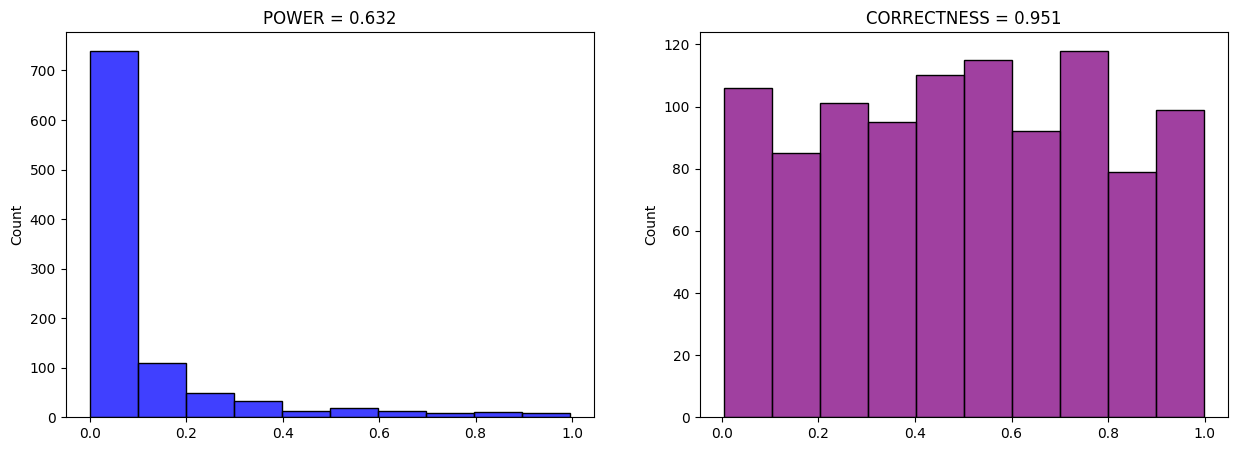

In [231]:
# cart_added_cnt - CUPED - t-тест

effect = []
power = []
correctness = []

a_covariate_mean = []
b_covariate_mean = []

a_mean = []
b_mean = []

a_cuped_mean = []
b_cuped_mean = []

a_var = []
b_var = []

a_cuped_var = []
b_cuped_var = []

for i in tqdm(range(1000)):
    
    groups = groups_splitter(shop_all.copy(), user_salt=salt_generator())
    df = pd.merge(shop_all, groups, how="left", on=['user_id']).drop_duplicates()
    
    a = df[df['group'] == 'A']['cart_added_cnt']
    b = df[df['group'] == 'B']['cart_added_cnt']
    
    df_cuped = cuped_transform(df, ['cart_added_cnt'])
    
    a_cuped = df_cuped[df_cuped['group'] == 'A']['cart_added_cnt_cuped']
    b_cuped = df_cuped[df_cuped['group'] == 'B']['cart_added_cnt_cuped']
    b_cuped_effect = b_cuped * 1.01
    
    effect.append((b_cuped_effect.mean() - a_cuped.mean()) / a_cuped.mean())

    p_power, p_cor = stats.ttest_ind(a_cuped, b_cuped_effect)[1], stats.ttest_ind(a_cuped, b_cuped)[1]
    power.append(p_power)
    correctness.append(p_cor)
    
    
    a_covariate = df[df['group'] == 'A']['cart_added_cnt_covariate']
    b_covariate = df[df['group'] == 'B']['cart_added_cnt_covariate']
    a_covariate_mean.append(a_covariate.mean())
    b_covariate_mean.append(b_covariate.mean())

    a_mean.append(a.mean())
    b_mean.append(b.mean())

    a_cuped_mean.append(a_cuped.mean())
    b_cuped_mean.append(b_cuped.mean())

    a_var.append(a.var())
    b_var.append(b.var())

    a_cuped_var.append(a_cuped.var())
    b_cuped_var.append(b_cuped.var())
    
power = np.array(power)
correctness = np.array(correctness)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data=power, bins=10, color='blue', ax=ax[0])
ax[0].set_title(f'POWER = {power[power < 0.05].shape[0] / power.shape[0]}')

sns.histplot(data=correctness, bins=10, color='purple', ax=ax[1])
ax[1].set_title(f'CORRECTNESS = {1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])}')

print(f'Effect = {round(np.array(effect).mean() * 100, 2)}%')
print()
print('СРЕДНЯЯ КОВАРИАТ: \nГруппа A: {}, Группа B: {} \n\n\
СРЕДНЯЯ МЕТРИК: \nГруппа A: {}, Группа B: {} \n\
СРЕДНЯЯ CUPED МЕТРИК: \nГруппа A: {}, Группа B: {} \n\n\
ДИСПЕРСИЯ МЕТРИК: \nГруппа A: {}, Группа B: {} \n\
ДИСПЕРСИЯ CUPED МЕТРИК: \nГруппа A: {}, Группа B: {} \n'.format
     (round(np.array(a_covariate_mean).mean(), 3), round(np.array(b_covariate_mean).mean(), 3),
      round(np.array(a_mean).mean(), 3), round(np.array(b_mean).mean(), 3),
      round(np.array(a_cuped_mean).mean(), 3), round(np.array(b_cuped_mean).mean(), 3),
      round(np.array(a_var).mean(), 3), round(np.array(b_var).mean(), 3),
      round(np.array(a_cuped_var).mean(), 3), round(np.array(b_cuped_var).mean(), 3)
     ))

100%|██████████| 1000/1000 [23:05<00:00,  1.39s/it]


Ln Effect = 1%

СРЕДНЯЯ КОВАРИАТ: 
Группа A: 0.083, Группа B: 0.083 

СРЕДНЯЯ МЕТРИК: 
Группа A: 0.081, Группа B: 0.081 
СРЕДНЯЯ CUPED МЕТРИК: 
Группа A: 0.081, Группа B: 0.081 

ДИСПЕРСИЯ МЕТРИК: 
Группа A: 0.065, Группа B: 0.065 
ДИСПЕРСИЯ CUPED МЕТРИК: 
Группа A: 0.002, Группа B: 0.002 



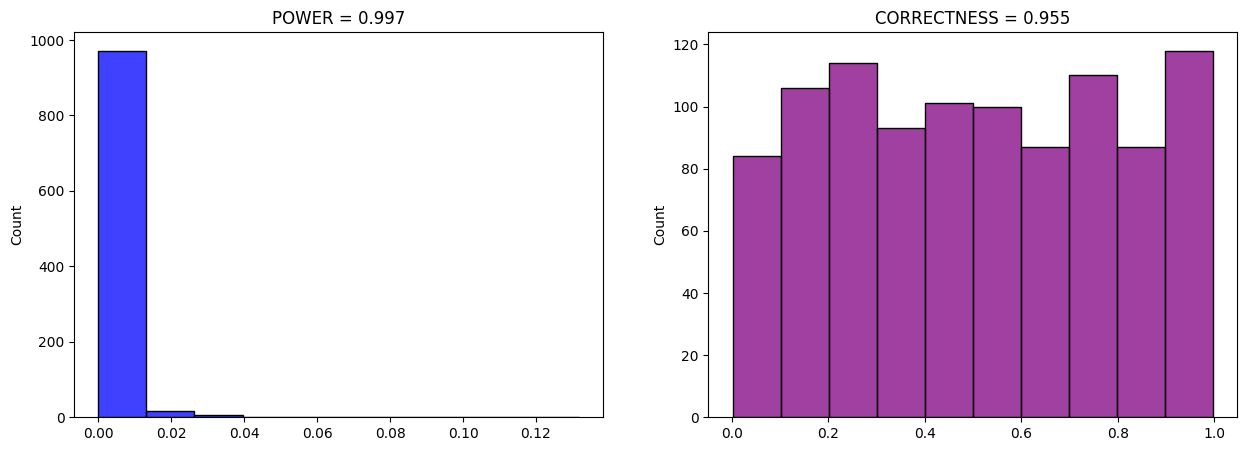

In [232]:
# cart_added_cnt - логарифмирование - CUPED - t-тест

shop_all['cart_added_cnt_ln'] = np.log(shop_all['cart_added_cnt'] + 1)
shop_all['cart_added_cnt_ln_covariate'] = np.log(shop_all['cart_added_cnt_covariate'] + 1)

effect = []
power = []
correctness = []

a_covariate_mean = []
b_covariate_mean = []

a_mean = []
b_mean = []

a_cuped_mean = []
b_cuped_mean = []

a_var = []
b_var = []

a_cuped_var = []
b_cuped_var = []

for i in tqdm(range(1000)):
    
    groups = groups_splitter(shop_all.copy(), user_salt=salt_generator())
    df = pd.merge(shop_all, groups, how="left", on=['user_id']).drop_duplicates()
    
    a = df[df['group'] == 'A']['cart_added_cnt_ln']
    b = df[df['group'] == 'B']['cart_added_cnt_ln']
    
    df_cuped = cuped_transform(df, ['cart_added_cnt_ln'])
    
    a_cuped = df_cuped[df_cuped['group'] == 'A']['cart_added_cnt_ln_cuped']
    b_cuped = df_cuped[df_cuped['group'] == 'B']['cart_added_cnt_ln_cuped']
    b_cuped_effect = b_cuped * 1.01
    
    effect.append((b_cuped_effect.mean() - a_cuped.mean()) / a_cuped.mean())

    p_power, p_cor = stats.ttest_ind(a_cuped, b_cuped_effect)[1], stats.ttest_ind(a_cuped, b_cuped)[1]
    power.append(p_power)
    correctness.append(p_cor)
    
    
    a_covariate = df[df['group'] == 'A']['cart_added_cnt_ln_covariate']
    b_covariate = df[df['group'] == 'B']['cart_added_cnt_ln_covariate']
    a_covariate_mean.append(a_covariate.mean())
    b_covariate_mean.append(b_covariate.mean())

    a_mean.append(a.mean())
    b_mean.append(b.mean())

    a_cuped_mean.append(a_cuped.mean())
    b_cuped_mean.append(b_cuped.mean())

    a_var.append(a.var())
    b_var.append(b.var())

    a_cuped_var.append(a_cuped.var())
    b_cuped_var.append(b_cuped.var())
    
power = np.array(power)
correctness = np.array(correctness)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data=power, bins=10, color='blue', ax=ax[0])
ax[0].set_title(f'POWER = {power[power < 0.05].shape[0] / power.shape[0]}')

sns.histplot(data=correctness, bins=10, color='purple', ax=ax[1])
ax[1].set_title(f'CORRECTNESS = {1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])}')

print(f'Ln Effect = {round(np.array(effect).mean() * 100)}%')
print()
print('СРЕДНЯЯ КОВАРИАТ: \nГруппа A: {}, Группа B: {} \n\n\
СРЕДНЯЯ МЕТРИК: \nГруппа A: {}, Группа B: {} \n\
СРЕДНЯЯ CUPED МЕТРИК: \nГруппа A: {}, Группа B: {} \n\n\
ДИСПЕРСИЯ МЕТРИК: \nГруппа A: {}, Группа B: {} \n\
ДИСПЕРСИЯ CUPED МЕТРИК: \nГруппа A: {}, Группа B: {} \n'.format
     (round(np.array(a_covariate_mean).mean(), 3), round(np.array(b_covariate_mean).mean(), 3),
      round(np.array(a_mean).mean(), 3), round(np.array(b_mean).mean(), 3),
      round(np.array(a_cuped_mean).mean(), 3), round(np.array(b_cuped_mean).mean(), 3),
      round(np.array(a_var).mean(), 3), round(np.array(b_var).mean(), 3),
      round(np.array(a_cuped_var).mean(), 3), round(np.array(b_cuped_var).mean(), 3)
     ))

100%|██████████| 1000/1000 [28:04<00:00,  1.68s/it]


Effect = 0.01%

СРЕДНЯЯ КОВАРИАТ: 
Группа A: 0.142, Группа B: 0.142 

СРЕДНЯЯ МЕТРИК: 
Группа A: 0.137, Группа B: 0.137 
СРЕДНЯЯ CUPED МЕТРИК: 
Группа A: 0.137, Группа B: 0.137 

ДИСПЕРСИЯ МЕТРИК: 
Группа A: 0.4, Группа B: 0.405 
ДИСПЕРСИЯ CUPED МЕТРИК: 
Группа A: 0.02, Группа B: 0.02 



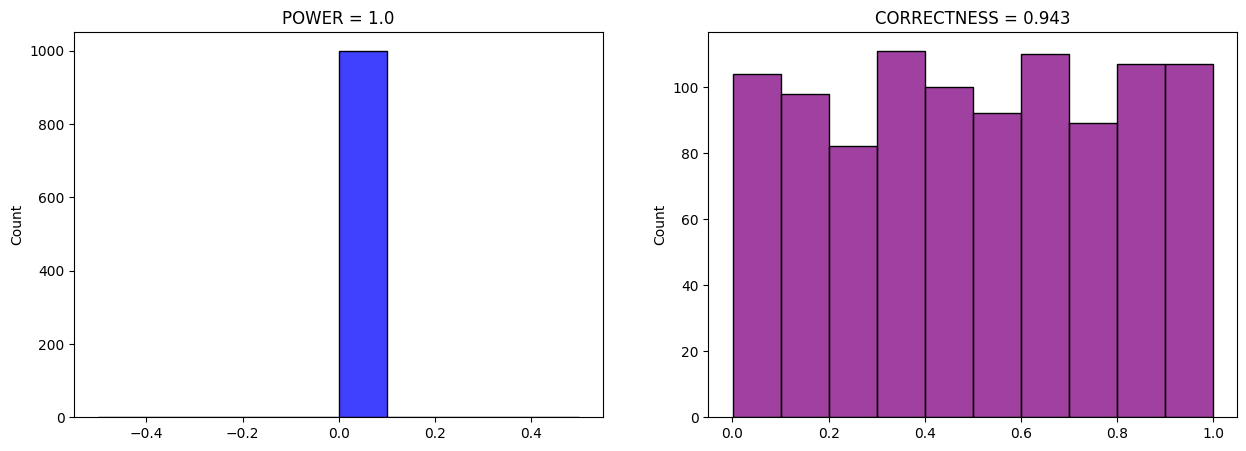

In [233]:
# cart_added_cnt - CUPED - ранговая трансформация - t-тест

effect = []
power = []
correctness = []

a_covariate_mean = []
b_covariate_mean = []

a_mean = []
b_mean = []

a_cuped_mean = []
b_cuped_mean = []

a_var = []
b_var = []

a_cuped_var = []
b_cuped_var = []

for i in tqdm(range(1000)):
    
    # Splitter
    groups = groups_splitter(shop_all.copy(), user_salt=salt_generator())
    df = pd.merge(shop_all, groups, how="left", on=['user_id']).drop_duplicates()
    
    a = df[df['group'] == 'A']['cart_added_cnt']
    b = df[df['group'] == 'B']['cart_added_cnt']
    
    # CUPED
    df_cuped = cuped_transform(df, ['cart_added_cnt'])
    
    a_cuped = df_cuped[df_cuped['group'] == 'A']['cart_added_cnt_cuped']
    b_cuped = df_cuped[df_cuped['group'] == 'B']['cart_added_cnt_cuped']
    b_cuped_effect = b_cuped * 1.0001
    
    effect.append((b_cuped_effect.mean() - a_cuped.mean()) / a_cuped.mean())
    
    # Ranker
    df_cuped_ranked = df_ranker(df_cuped[df_cuped.group == 'A'], df_cuped[df_cuped.group == 'B'], 'cart_added_cnt_cuped')
    a_cuped_ranks = df_cuped_ranked[(df_cuped_ranked['group'] == 'A')]['rank']
    b_cuped_ranks = df_cuped_ranked[(df_cuped_ranked['group'] == 'B')]['rank']
    
    df_cuped_b = df_cuped[df_cuped.group == 'B'].drop(columns=['cart_added_cnt_cuped'])
    df_cuped_b['cart_added_cnt_cuped'] = list(b_cuped_effect)
    
    df_cuped_effect_ranked = df_ranker(df_cuped[df_cuped.group == 'A'], df_cuped_b, 'cart_added_cnt_cuped')
    a_cuped_ranks_effect = df_cuped_effect_ranked[(df_cuped_ranked['group'] == 'A')]['rank']
    b_cuped_effect_ranks = df_cuped_effect_ranked[(df_cuped_ranked['group'] == 'B')]['rank']

    # Test
    p_power, p_cor = stats.ttest_ind(a_cuped_ranks_effect, b_cuped_effect_ranks)[1],\
                     stats.ttest_ind(a_cuped_ranks, b_cuped_ranks)[1]
    
    power.append(p_power)
    correctness.append(p_cor)
    
    # CUPED control
    a_covariate = df[df['group'] == 'A']['cart_added_cnt_covariate']
    b_covariate = df[df['group'] == 'B']['cart_added_cnt_covariate']
    a_covariate_mean.append(a_covariate.mean())
    b_covariate_mean.append(b_covariate.mean())

    a_mean.append(a.mean())
    b_mean.append(b.mean())

    a_cuped_mean.append(a_cuped.mean())
    b_cuped_mean.append(b_cuped.mean())

    a_var.append(a.var())
    b_var.append(b.var())

    a_cuped_var.append(a_cuped.var())
    b_cuped_var.append(b_cuped.var())
    
# Output
power = np.array(power)
correctness = np.array(correctness)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data=power, bins=10, color='blue', ax=ax[0])
ax[0].set_title(f'POWER = {power[power < 0.05].shape[0] / power.shape[0]}')

sns.histplot(data=correctness, bins=10, color='purple', ax=ax[1])
ax[1].set_title(f'CORRECTNESS = {1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])}')

print(f'Effect = {round(np.array(effect).mean() * 100, 2)}%')
print()
print('СРЕДНЯЯ КОВАРИАТ: \nГруппа A: {}, Группа B: {} \n\n\
СРЕДНЯЯ МЕТРИК: \nГруппа A: {}, Группа B: {} \n\
СРЕДНЯЯ CUPED МЕТРИК: \nГруппа A: {}, Группа B: {} \n\n\
ДИСПЕРСИЯ МЕТРИК: \nГруппа A: {}, Группа B: {} \n\
ДИСПЕРСИЯ CUPED МЕТРИК: \nГруппа A: {}, Группа B: {} \n'.format
     (round(np.array(a_covariate_mean).mean(), 3), round(np.array(b_covariate_mean).mean(), 3),
      round(np.array(a_mean).mean(), 3), round(np.array(b_mean).mean(), 3),
      round(np.array(a_cuped_mean).mean(), 3), round(np.array(b_cuped_mean).mean(), 3),
      round(np.array(a_var).mean(), 3), round(np.array(b_var).mean(), 3),
      round(np.array(a_cuped_var).mean(), 3), round(np.array(b_cuped_var).mean(), 3)
     ))

100%|██████████| 1000/1000 [28:59<00:00,  1.74s/it]


Effect = 0.01%

СРЕДНЯЯ КОВАРИАТ: 
Группа A: 0.142, Группа B: 0.142 

СРЕДНЯЯ МЕТРИК: 
Группа A: 0.137, Группа B: 0.137 
СРЕДНЯЯ CUPED МЕТРИК: 
Группа A: 0.137, Группа B: 0.137 

ДИСПЕРСИЯ МЕТРИК: 
Группа A: 0.404, Группа B: 0.401 
ДИСПЕРСИЯ CUPED МЕТРИК: 
Группа A: 0.02, Группа B: 0.02 



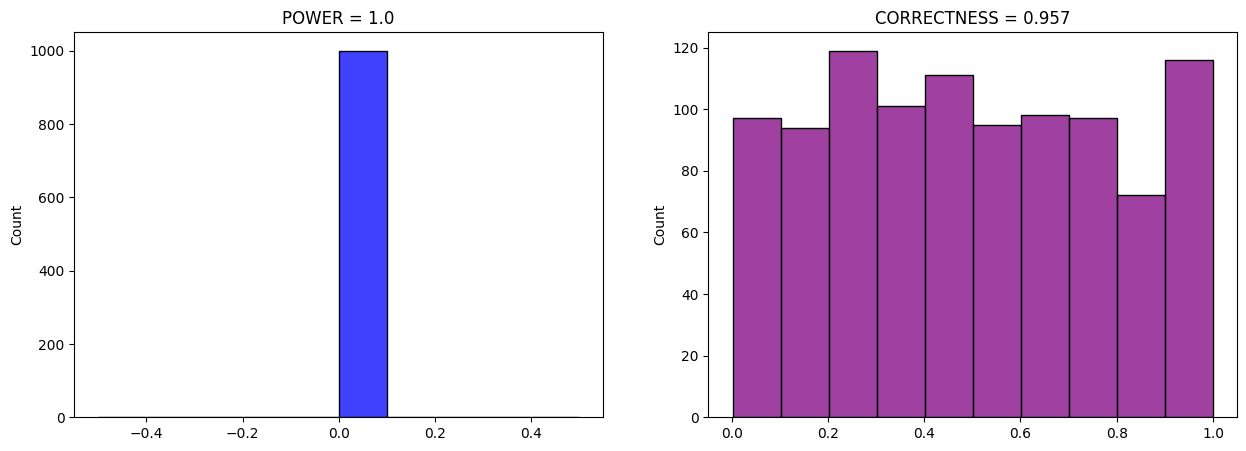

In [234]:
# cart_added_cnt - CUPED - Манн-Уитни

effect = []
power = []
correctness = []

a_covariate_mean = []
b_covariate_mean = []

a_mean = []
b_mean = []

a_cuped_mean = []
b_cuped_mean = []

a_var = []
b_var = []

a_cuped_var = []
b_cuped_var = []

for i in tqdm(range(1000)):
    
    # Splitter
    groups = groups_splitter(shop_all.copy(), user_salt=salt_generator())
    df = pd.merge(shop_all, groups, how="left", on=['user_id']).drop_duplicates()
    
    a = df[df['group'] == 'A']['cart_added_cnt']
    b = df[df['group'] == 'B']['cart_added_cnt']
    
    # CUPED
    df_cuped = cuped_transform(df, ['cart_added_cnt'])
    
    a_cuped = df_cuped[df_cuped['group'] == 'A']['cart_added_cnt_cuped']
    b_cuped = df_cuped[df_cuped['group'] == 'B']['cart_added_cnt_cuped']
    b_cuped_effect = b_cuped * 1.0001
    
    effect.append((b_cuped_effect.mean() - a_cuped.mean()) / a_cuped.mean())
    
    p_power, p_cor = stats.mannwhitneyu(a_cuped, b_cuped_effect)[1], stats.mannwhitneyu(a_cuped, b_cuped)[1]
    
    power.append(p_power)
    correctness.append(p_cor)
    
    # CUPED control
    a_covariate = df[df['group'] == 'A']['cart_added_cnt_covariate']
    b_covariate = df[df['group'] == 'B']['cart_added_cnt_covariate']
    a_covariate_mean.append(a_covariate.mean())
    b_covariate_mean.append(b_covariate.mean())

    a_mean.append(a.mean())
    b_mean.append(b.mean())

    a_cuped_mean.append(a_cuped.mean())
    b_cuped_mean.append(b_cuped.mean())

    a_var.append(a.var())
    b_var.append(b.var())

    a_cuped_var.append(a_cuped.var())
    b_cuped_var.append(b_cuped.var())
    
# Output
power = np.array(power)
correctness = np.array(correctness)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data=power, bins=10, color='blue', ax=ax[0])
ax[0].set_title(f'POWER = {power[power < 0.05].shape[0] / power.shape[0]}')

sns.histplot(data=correctness, bins=10, color='purple', ax=ax[1])
ax[1].set_title(f'CORRECTNESS = {1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])}')

print(f'Effect = {round(np.array(effect).mean() * 100, 2)}%')
print()
print('СРЕДНЯЯ КОВАРИАТ: \nГруппа A: {}, Группа B: {} \n\n\
СРЕДНЯЯ МЕТРИК: \nГруппа A: {}, Группа B: {} \n\
СРЕДНЯЯ CUPED МЕТРИК: \nГруппа A: {}, Группа B: {} \n\n\
ДИСПЕРСИЯ МЕТРИК: \nГруппа A: {}, Группа B: {} \n\
ДИСПЕРСИЯ CUPED МЕТРИК: \nГруппа A: {}, Группа B: {} \n'.format
     (round(np.array(a_covariate_mean).mean(), 3), round(np.array(b_covariate_mean).mean(), 3),
      round(np.array(a_mean).mean(), 3), round(np.array(b_mean).mean(), 3),
      round(np.array(a_cuped_mean).mean(), 3), round(np.array(b_cuped_mean).mean(), 3),
      round(np.array(a_var).mean(), 3), round(np.array(b_var).mean(), 3),
      round(np.array(a_cuped_var).mean(), 3), round(np.array(b_cuped_var).mean(), 3)
     ))

**CUPED-преобразование позволило значительно ускорить тест. Предварительное логарифмирование усилило эффект. Ранговая трансформация на CUPED дала такой же сильный эффект, как и на чистой метрике: изменение в доли процента ловится со 100% мощностью.**

# 3. Бакетирование
3. Реализовать разбивку на бакеты, оценить t-критерием и сравнить с результатом без бакетирования:
- на логнормальном распределении (сгенерированные данные)
- на гамма-распределении (сгенерированные данные)
- на метрике cart_added_cnt

In [235]:
def array_buckets(a, buckets=200):
  buckets = np.random.choice(a, size=(buckets, int(len(a)/buckets)), replace=False)
  a_buckets = []
  for i in range(len(buckets)):
    a_buckets.append(buckets[i].mean())
  return np.array(a_buckets)

In [10]:
def df_buckets(df, user_salt=None):
    
    if user_salt == None:
        salt = salt_generator()
    else:
        salt = user_salt
    
    df['hash_bucket'] = ((df['user_id'].astype(str)) + '#' + salt).apply(lambda x: hashlib.sha256(x.encode('utf-8')).hexdigest())

    df['bucket'] = (df['hash_bucket'].str.slice(start=-6).apply(int, base=16) % 200)

    return df[['user_id', 'bucket']].drop_duplicates()

## Логнормальное

100%|██████████| 1000/1000 [00:01<00:00, 800.22it/s]


Effect = 5.24%


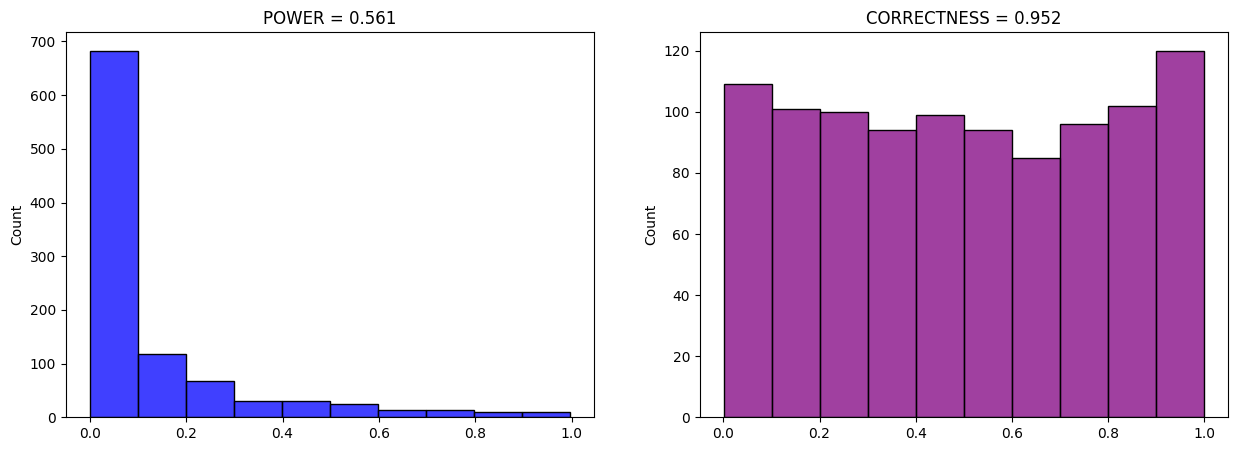

In [237]:
# Логнормальное - t-тест

effect = []
power = []
correctness = []

for i in tqdm(range(1000)):
    
    a = np.random.lognormal(mean=1.0, sigma=0.5, size=1000)
    b = np.random.lognormal(mean=1.0, sigma=0.5, size=1000)
    b_effect = np.random.lognormal(mean=1.05, sigma=0.5, size=1000)

    effect.append((b_effect.mean() - a.mean()) / a.mean())
  
    p_power, p_cor = stats.ttest_ind(a, b_effect)[1], stats.ttest_ind(a, b)[1]
    power.append(p_power)
    correctness.append(p_cor)
    
power = np.array(power)
correctness = np.array(correctness)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data=power, bins=10, color='blue', ax=ax[0])
ax[0].set_title(f'POWER = {power[power < 0.05].shape[0] / power.shape[0]}')

sns.histplot(data=correctness, bins=10, color='purple', ax=ax[1])
ax[1].set_title(f'CORRECTNESS = {1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])}')

print(f'Effect = {round(np.array(effect).mean() * 100, 2)}%')

100%|██████████| 1000/1000 [00:04<00:00, 232.71it/s]


Effect = 4.97%

СРЕДНЯЯ МЕТРИК: 
Группа A: 3.079, Группа B: 3.077 
СРЕДНЯЯ BUCKET МЕТРИК: 
Группа A: 3.079, Группа B: 3.077 

ДИСПЕРСИЯ МЕТРИК: 
Группа A: 2.691, Группа B: 2.682 
ДИСПЕРСИЯ BUCKET МЕТРИК: 
Группа A: 0.535, Группа B: 0.534 



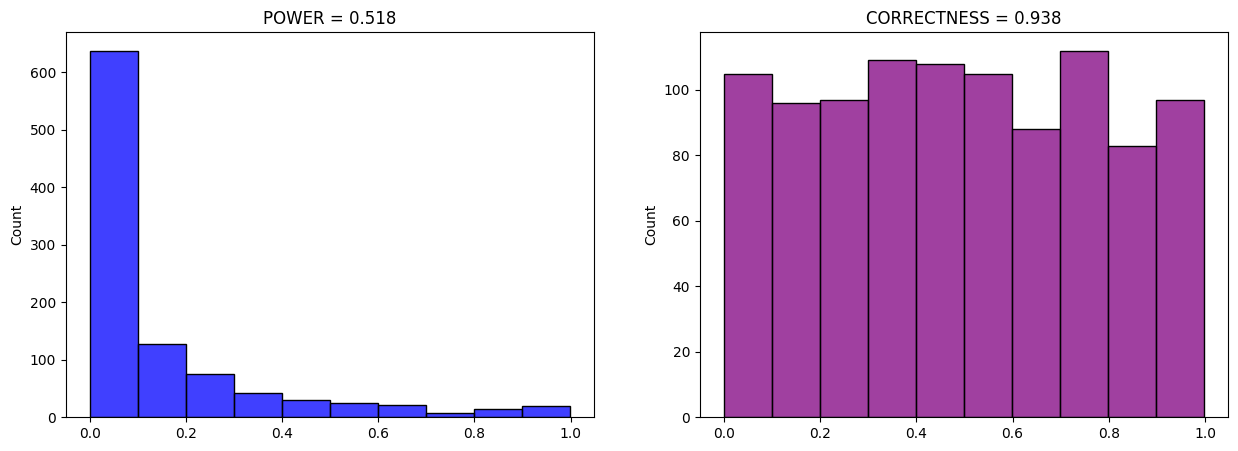

In [238]:
# Логнормальное - бакетирование - t-тест

effect = []
power = []
correctness = []

a_mean = []
b_mean = []

a_buckets_mean = []
b_buckets_mean = []

a_var = []
b_var = []

a_buckets_var = []
b_buckets_var = []

for i in tqdm(range(1000)):
    
    a = np.random.lognormal(mean=1.0, sigma=0.5, size=1000)
    b = np.random.lognormal(mean=1.0, sigma=0.5, size=1000)

    a_buckets = array_buckets(a)
    b_buckets = array_buckets(b)
    b_buckets_effect = b_buckets * 1.05

    effect.append((b_buckets_effect.mean() - a_buckets.mean()) / a_buckets.mean())
  
    p_power, p_cor = stats.ttest_ind(a_buckets, b_buckets_effect)[1], stats.ttest_ind(a_buckets, b_buckets)[1]
    power.append(p_power)
    correctness.append(p_cor)
    

    a_mean.append(a.mean())
    b_mean.append(b.mean())
    
    a_buckets_mean.append(a_buckets.mean())
    b_buckets_mean.append(b_buckets.mean())

    a_var.append(a.var())
    b_var.append(b.var())

    a_buckets_var.append(a_buckets.var())
    b_buckets_var.append(b_buckets.var())
    
power = np.array(power)
correctness = np.array(correctness)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data=power, bins=10, color='blue', ax=ax[0])
ax[0].set_title(f'POWER = {power[power < 0.05].shape[0] / power.shape[0]}')

sns.histplot(data=correctness, bins=10, color='purple', ax=ax[1])
ax[1].set_title(f'CORRECTNESS = {1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])}')

print(f'Effect = {round(np.array(effect).mean() * 100, 2)}%')
print()
print('СРЕДНЯЯ МЕТРИК: \nГруппа A: {}, Группа B: {} \n\
СРЕДНЯЯ BUCKET МЕТРИК: \nГруппа A: {}, Группа B: {} \n\n\
ДИСПЕРСИЯ МЕТРИК: \nГруппа A: {}, Группа B: {} \n\
ДИСПЕРСИЯ BUCKET МЕТРИК: \nГруппа A: {}, Группа B: {} \n'.format
     (
      round(np.array(a_mean).mean(), 3), round(np.array(b_mean).mean(), 3),
      round(np.array(a_buckets_mean).mean(), 3), round(np.array(b_buckets_mean).mean(), 3),
      round(np.array(a_var).mean(), 3), round(np.array(b_var).mean(), 3),
      round(np.array(a_buckets_var).mean(), 3), round(np.array(b_buckets_var).mean(), 3)
     ))

## Гамма

100%|██████████| 1000/1000 [00:00<00:00, 1406.15it/s]


Effect = 5.09%


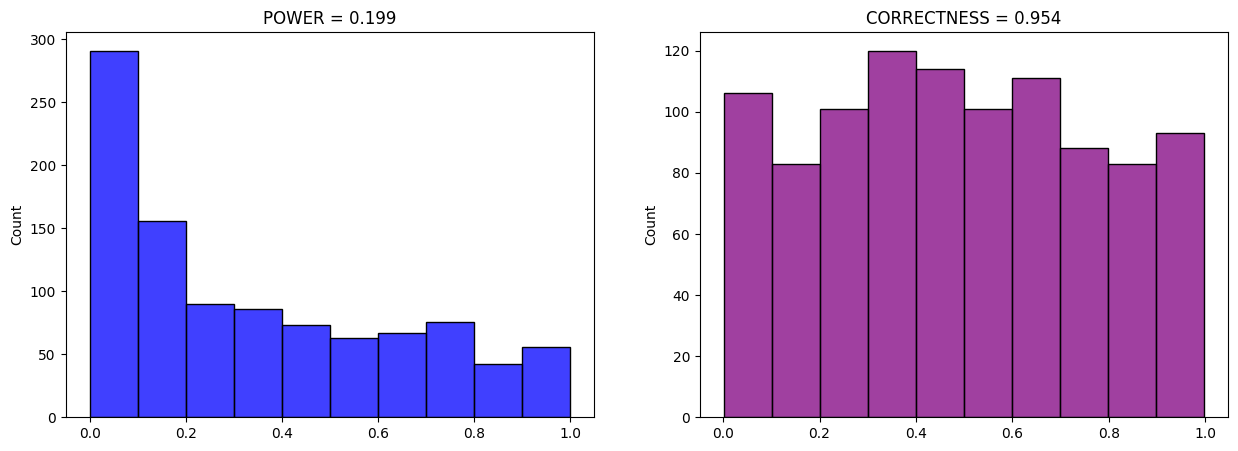

In [239]:
# Гамма - t-тест

effect = []
power = []
correctness = []

for i in tqdm(range(1000)):
    
    a = np.random.gamma(1, 1, 1000)
    b = np.random.gamma(1, 1, 1000)
    b_effect = np.random.gamma(1, 1, 1000) * 1.05

    effect.append((b_effect.mean() - a.mean()) / a.mean())
  
    p_power, p_cor = stats.ttest_ind(a, b_effect)[1], stats.ttest_ind(a, b)[1]
    power.append(p_power)
    correctness.append(p_cor)
    
power = np.array(power)
correctness = np.array(correctness)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data=power, bins=10, color='blue', ax=ax[0])
ax[0].set_title(f'POWER = {power[power < 0.05].shape[0] / power.shape[0]}')

sns.histplot(data=correctness, bins=10, color='purple', ax=ax[1])
ax[1].set_title(f'CORRECTNESS = {1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])}')

print(f'Effect = {round(np.array(effect).mean() * 100, 2)}%')

100%|██████████| 1000/1000 [00:03<00:00, 289.07it/s]


Effect = 5.34%

СРЕДНЯЯ МЕТРИК: 
Группа A: 1.0, Группа B: 1.002 
СРЕДНЯЯ BUCKET МЕТРИК: 
Группа A: 1.0, Группа B: 1.002 

ДИСПЕРСИЯ МЕТРИК: 
Группа A: 0.999, Группа B: 1.008 
ДИСПЕРСИЯ BUCKET МЕТРИК: 
Группа A: 0.199, Группа B: 0.2 



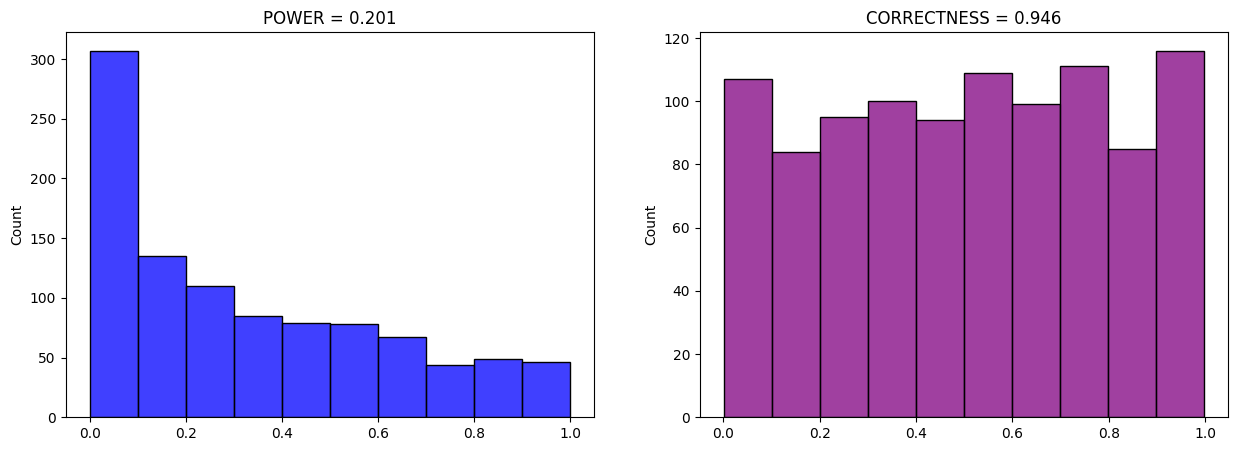

In [240]:
# Логнормальное - бакетирование - t-тест

effect = []
power = []
correctness = []

a_mean = []
b_mean = []

a_buckets_mean = []
b_buckets_mean = []

a_var = []
b_var = []

a_buckets_var = []
b_buckets_var = []

for i in tqdm(range(1000)):
    
    a = np.random.gamma(1, 1, 1000)
    b = np.random.gamma(1, 1, 1000)

    a_buckets = array_buckets(a)
    b_buckets = array_buckets(b)
    b_buckets_effect = b_buckets * 1.05

    effect.append((b_buckets_effect.mean() - a_buckets.mean()) / a_buckets.mean())
  
    p_power, p_cor = stats.ttest_ind(a_buckets, b_buckets_effect)[1], stats.ttest_ind(a_buckets, b_buckets)[1]
    power.append(p_power)
    correctness.append(p_cor)
    

    a_mean.append(a.mean())
    b_mean.append(b.mean())
    
    a_buckets_mean.append(a_buckets.mean())
    b_buckets_mean.append(b_buckets.mean())

    a_var.append(a.var())
    b_var.append(b.var())

    a_buckets_var.append(a_buckets.var())
    b_buckets_var.append(b_buckets.var())
    
power = np.array(power)
correctness = np.array(correctness)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data=power, bins=10, color='blue', ax=ax[0])
ax[0].set_title(f'POWER = {power[power < 0.05].shape[0] / power.shape[0]}')

sns.histplot(data=correctness, bins=10, color='purple', ax=ax[1])
ax[1].set_title(f'CORRECTNESS = {1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])}')

print(f'Effect = {round(np.array(effect).mean() * 100, 2)}%')
print()
print('СРЕДНЯЯ МЕТРИК: \nГруппа A: {}, Группа B: {} \n\
СРЕДНЯЯ BUCKET МЕТРИК: \nГруппа A: {}, Группа B: {} \n\n\
ДИСПЕРСИЯ МЕТРИК: \nГруппа A: {}, Группа B: {} \n\
ДИСПЕРСИЯ BUCKET МЕТРИК: \nГруппа A: {}, Группа B: {} \n'.format
     (
      round(np.array(a_mean).mean(), 3), round(np.array(b_mean).mean(), 3),
      round(np.array(a_buckets_mean).mean(), 3), round(np.array(b_buckets_mean).mean(), 3),
      round(np.array(a_var).mean(), 3), round(np.array(b_var).mean(), 3),
      round(np.array(a_buckets_var).mean(), 3), round(np.array(b_buckets_var).mean(), 3)
     ))

**На сгенерированных выборках бакетирование не ускорило тест.**

## Датафрейм

100%|██████████| 1000/1000 [33:35<00:00,  2.02s/it]


Effect = 1.13%

СРЕДНЯЯ МЕТРИК: 
Группа A: 0.137, Группа B: 0.137 
СРЕДНЯЯ BUCKET МЕТРИК: 
Группа A: 0.137, Группа B: 0.137 

ДИСПЕРСИЯ МЕТРИК: 
Группа A: 0.401, Группа B: 0.405 
ДИСПЕРСИЯ BUCKET МЕТРИК: 
Группа A: 0.001, Группа B: 0.001 



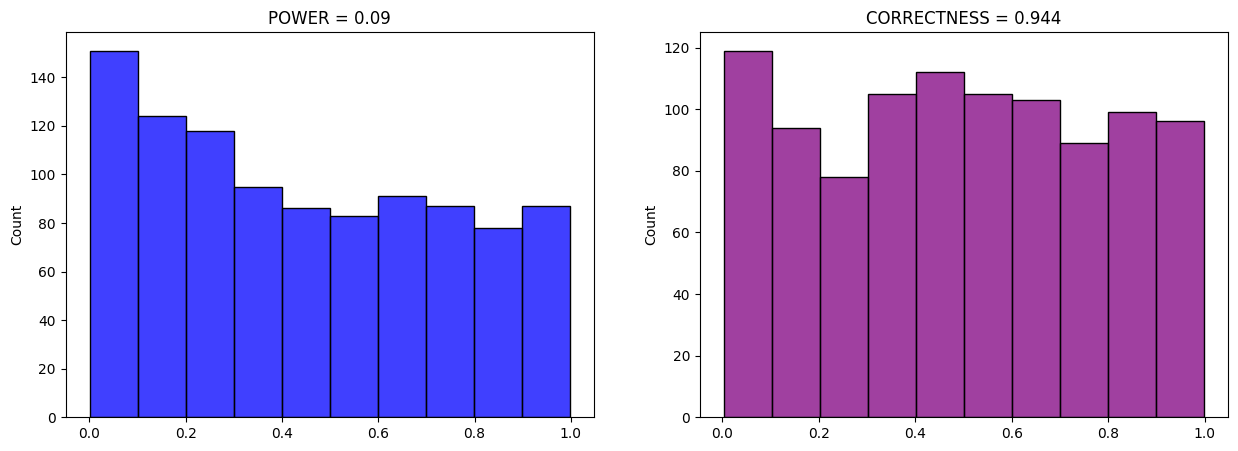

In [11]:
# cart_added_cnt - бакетирование - t-тест

effect = []
power = []
correctness = []

a_mean = []
b_mean = []

a_buckets_mean = []
b_buckets_mean = []

a_var = []
b_var = []

a_buckets_var = []
b_buckets_var = []

for i in tqdm(range(1000)):
    
    groups = groups_splitter(shop_december.copy(), user_salt=salt_generator())
    df = pd.merge(shop_december, groups, how="left", on=['user_id']).drop_duplicates()

    a = df[df['group'] == 'A']
    a_buckets = df_buckets(a.copy(), user_salt=salt_generator())
    a_buckets = pd.merge(a, a_buckets, how="left", on=['user_id']).drop_duplicates()
    a_buckets = a_buckets.groupby(by='bucket').cart_added_cnt.mean()
    a = a.cart_added_cnt

    b = df[df['group'] == 'B']
    b_buckets = df_buckets(b.copy(), user_salt=salt_generator())
    b_buckets = pd.merge(b, b_buckets, how="left", on=['user_id']).drop_duplicates()
    b_buckets = b_buckets.groupby(by='bucket').cart_added_cnt.mean()
    b = b.cart_added_cnt
    b_buckets_effect = b_buckets * 1.01

    effect.append((b_buckets_effect.mean() - a_buckets.mean()) / a_buckets.mean())
  
    p_power, p_cor = stats.ttest_ind(a_buckets, b_buckets_effect)[1], stats.ttest_ind(a_buckets, b_buckets)[1]
    power.append(p_power)
    correctness.append(p_cor)
    

    a_mean.append(a.mean())
    b_mean.append(b.mean())
    
    a_buckets_mean.append(a_buckets.mean())
    b_buckets_mean.append(b_buckets.mean())

    a_var.append(a.var())
    b_var.append(b.var())

    a_buckets_var.append(a_buckets.var())
    b_buckets_var.append(b_buckets.var())
    
power = np.array(power)
correctness = np.array(correctness)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data=power, bins=10, color='blue', ax=ax[0])
ax[0].set_title(f'POWER = {power[power < 0.05].shape[0] / power.shape[0]}')

sns.histplot(data=correctness, bins=10, color='purple', ax=ax[1])
ax[1].set_title(f'CORRECTNESS = {1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])}')

print(f'Effect = {round(np.array(effect).mean() * 100, 2)}%')
print()
print('СРЕДНЯЯ МЕТРИК: \nГруппа A: {}, Группа B: {} \n\
СРЕДНЯЯ BUCKET МЕТРИК: \nГруппа A: {}, Группа B: {} \n\n\
ДИСПЕРСИЯ МЕТРИК: \nГруппа A: {}, Группа B: {} \n\
ДИСПЕРСИЯ BUCKET МЕТРИК: \nГруппа A: {}, Группа B: {} \n'.format
     (
      round(np.array(a_mean).mean(), 3), round(np.array(b_mean).mean(), 3),
      round(np.array(a_buckets_mean).mean(), 3), round(np.array(b_buckets_mean).mean(), 3),
      round(np.array(a_var).mean(), 3), round(np.array(b_var).mean(), 3),
      round(np.array(a_buckets_var).mean(), 3), round(np.array(b_buckets_var).mean(), 3)
     ))

**Бакетирование на датафрейме тоже значительно сократило дисперсию и сделало распределение метрики более нормальным, но не повлияло на мощность теста.**

# 4
4. Реализовать постстратификацию на данных shop_metrics_old для метрики cart_added_cnt:
- на сочетании пола и возраста (возраст разбить на подгруппы: 18-24, 25-45, 46-60, 61-75, 76+)
- подсчитать результаты для случая без постстратификации и с постстратификацией
- на сколько сократилась диспресия?
- проверить мощность и корректность t-критерия для постстратифицированного случая

In [12]:
user_info = pd.read_csv('/content/drive/MyDrive/HW/shop_df_users.csv').drop(columns='Unnamed: 0')

In [13]:
shop_w_features = pd.merge(shop_september, user_info, on=['user_id'], how='left')

In [14]:
shop_w_features['age_group'] = shop_w_features['user_age'].apply(
    lambda x: '18-24' if 18 <= x <= 24  else(
        '25-45' if 25 <= x <= 45 else(
            '46-60' if 46 <= x <= 60 else(
               '61-75' if 61 <= x <= 75 else '76+' 
            ))))

shop_w_features['age_sex_group'] = shop_w_features.user_sex + '_' + shop_w_features.age_group

In [15]:
def poststrat(df, feature, strats, hue):
  n = df[hue].nunique()
  weights = {}
  for i in range(0, df[strats].nunique()):
    key = df[strats].value_counts().index[i]
    weights[key] = df[strats].value_counts()[i] / n

  df_mean = 0
  df_var = 0
  for i in weights:
    df_mean += df[df[strats] == i][feature].mean() * weights[i]
    df_var += df[df[strats] == i][feature].var() * weights[i]

  df_std = np.sqrt(df_var)
  df_n = len(df)

  return df_mean, df_std, df_n

100%|██████████| 1000/1000 [33:49<00:00,  2.03s/it]


Effect = 0.97%


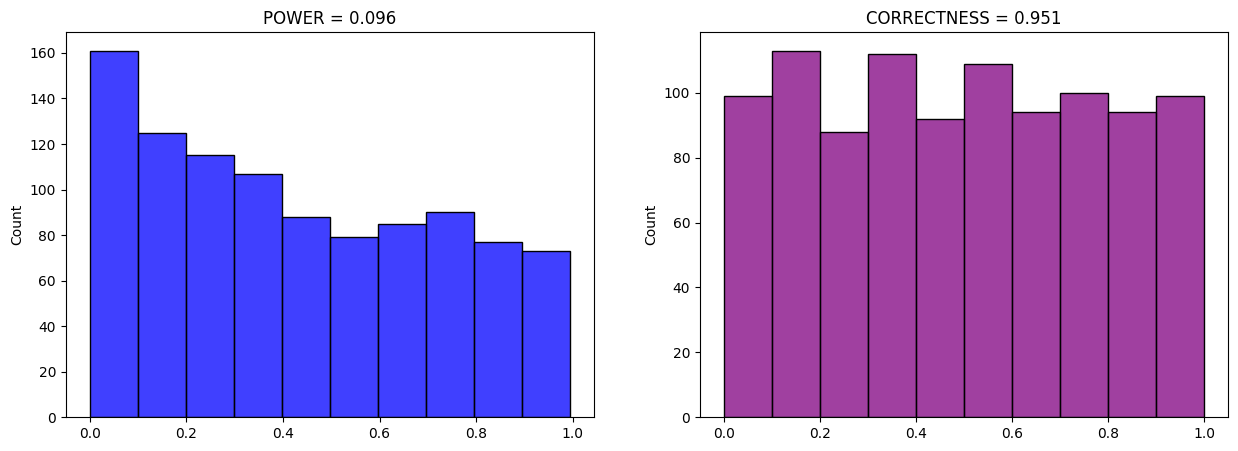

In [16]:
# cart_added_cnt (september) - t-тест

effect = []
power = []
correctness = []

for i in tqdm(range(1000)):
    
    groups = groups_splitter(shop_september.copy(), user_salt=salt_generator())
    df = pd.merge(shop_september, groups, how="left", on=['user_id']).drop_duplicates()
    
    a = df[df['group'] == 'A']['cart_added_cnt']
    b = df[df['group'] == 'B']['cart_added_cnt']
    b_effect = b * 1.01
    
    effect.append((b_effect.mean() - a.mean()) / a.mean())

    p_power, p_cor = stats.ttest_ind(a, b_effect)[1], stats.ttest_ind(a, b)[1]
    power.append(p_power)
    correctness.append(p_cor)
    
power = np.array(power)
correctness = np.array(correctness)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data=power, bins=10, color='blue', ax=ax[0])
ax[0].set_title(f'POWER = {power[power < 0.05].shape[0] / power.shape[0]}')

sns.histplot(data=correctness, bins=10, color='purple', ax=ax[1])
ax[1].set_title(f'CORRECTNESS = {1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])}')

print(f'Effect = {round(np.array(effect).mean() * 100, 2)}%')

100%|██████████| 1000/1000 [1:23:58<00:00,  5.04s/it]


Effect = 1.12%

СРЕДНЯЯ МЕТРИК: 
Группа A: 0.121, Группа B: 0.121 
СРЕДНЯЯ POSTSTRAT МЕТРИК: 
Группа A: 0.121, Группа B: 0.121 

ДИСПЕРСИЯ МЕТРИК: 
Группа A: 0.34482, Группа B: 0.34629 
ДИСПЕРСИЯ POSTSTRAT МЕТРИК: 
Группа A: 0.34482, Группа B: 0.34628 
ПОЛНОЕ СОВПАДЕНИЕ ДИСПЕРСИЙ POSTSTRAT И ИСХОДНЫХ МЕТРИК: 
Группа A: 0.0 случаев, Группа B: 0.0 случаев 



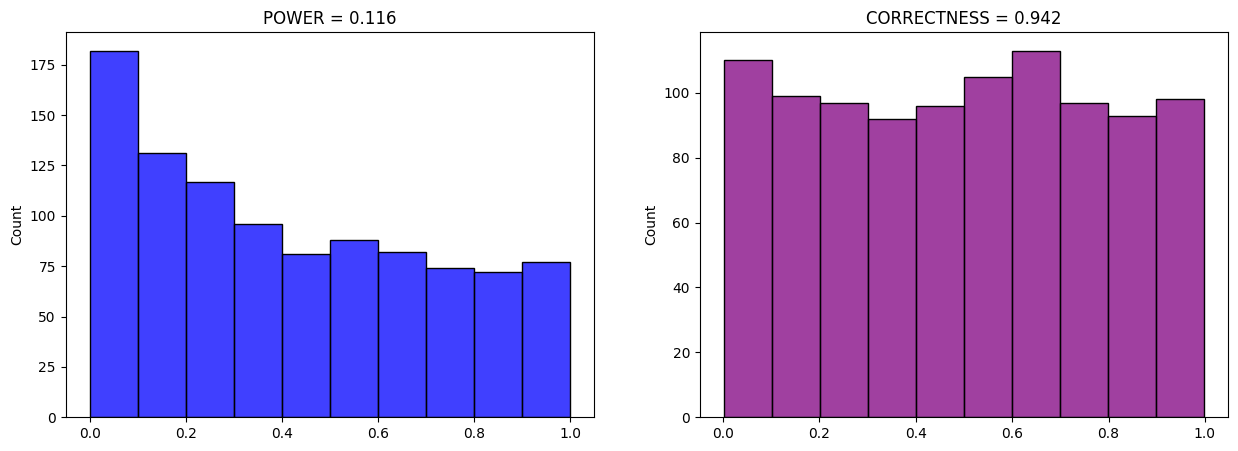

In [17]:
# cart_added_cnt (september) - постстратификация - t-тест

effect = []
power = []
correctness = []

a_mean = []
b_mean = []

a_strat_mean = []
b_strat_mean = []

a_var = []
b_var = []

a_strat_var = []
b_strat_var = []

a_var_diff = []
b_var_diff = []

for i in tqdm(range(1000)):
    
    groups = groups_splitter(shop_w_features.copy(), user_salt=salt_generator())
    df = pd.merge(shop_w_features, groups, how="left", on=['user_id']).drop_duplicates()
    
    a = df[df['group'] == 'A']
    a_strat_stats = poststrat(a, 'cart_added_cnt', 'age_sex_group', 'user_id')
    a = a.cart_added_cnt


    b = df[df['group'] == 'B']
    b_strat_stats = poststrat(b, 'cart_added_cnt', 'age_sex_group', 'user_id')
    b_values = b.cart_added_cnt

    b_effect = b_values * 1.01

    b_effect_df = b.drop(columns=['cart_added_cnt'])
    b_effect_df['cart_added_cnt'] = list(b_effect)
    b_effect_strat_stats = poststrat(b_effect_df, 'cart_added_cnt', 'age_sex_group', 'user_id')
    b = b_values
    
    effect.append((b_effect.mean() - a.mean()) / a.mean())

    p_power, p_cor = stats.ttest_ind_from_stats(*a_strat_stats, *b_effect_strat_stats)[1], stats.ttest_ind_from_stats(*a_strat_stats, *b_strat_stats)[1]
    power.append(p_power)
    correctness.append(p_cor)
    

    a_mean.append(a.mean())
    b_mean.append(b.mean())

    a_strat_mean.append(a_strat_stats[0])
    b_strat_mean.append(b_strat_stats[0])

    a_var.append(a.var())
    b_var.append(b.var())

    a_strat_var.append(a_strat_stats[1] ** 2)
    b_strat_var.append(b_strat_stats[1] ** 2)

    a_var_diff.append(a_strat_var == a_var)
    b_var_diff.append(b_strat_var == b_var)
    
power = np.array(power)
correctness = np.array(correctness)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data=power, bins=10, color='blue', ax=ax[0])
ax[0].set_title(f'POWER = {power[power < 0.05].shape[0] / power.shape[0]}')

sns.histplot(data=correctness, bins=10, color='purple', ax=ax[1])
ax[1].set_title(f'CORRECTNESS = {1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])}')

print(f'Effect = {round(np.array(effect).mean() * 100, 2)}%')
print()
print('СРЕДНЯЯ МЕТРИК: \nГруппа A: {}, Группа B: {} \n\
СРЕДНЯЯ POSTSTRAT МЕТРИК: \nГруппа A: {}, Группа B: {} \n\n\
ДИСПЕРСИЯ МЕТРИК: \nГруппа A: {}, Группа B: {} \n\
ДИСПЕРСИЯ POSTSTRAT МЕТРИК: \nГруппа A: {}, Группа B: {} \n\
ПОЛНОЕ СОВПАДЕНИЕ ДИСПЕРСИЙ POSTSTRAT И ИСХОДНЫХ МЕТРИК: \nГруппа A: {} случаев, Группа B: {} случаев \n'.format
     (
      round(np.array(a_mean).mean(), 3), round(np.array(b_mean).mean(), 3),
      round(np.array(a_strat_mean).mean(), 3), round(np.array(b_strat_mean).mean(), 3),
      round(np.array(a_var).mean(), 5), round(np.array(b_var).mean(), 5),
      round(np.array(a_strat_var).mean(), 5), round(np.array(b_strat_var).mean(), 5),
      round(sum(a_var_diff) / len(a_var_diff), 3), round(sum(b_var_diff) / len(b_var_diff), 3)
     ))

**Постстратификация практически не сократила дисперсию, так как внутри страт она такая же высокая. Поэтому мощность теста не увеличилась.**

**Результативность методов на метрике cart_added_cnt:**
1. Ранговая трансформация во всех случаях очень сильно ускорила тест с соблюдением высокой корректности.
2. Логарифмирование + CUPED - на втором месте.
3. Просто CUPED - на третьем месте.
4. Разбиение выборок на бакеты и страты не повысило мощность теста, хотя бакетирование значительно сократило дисперсии.